Semi-supervised Community Detection using Graph Convolutional Network
=====================

Predicting community memberships of a network of entities is a common task in many real-world scenarios
working with graph data. In this tutorial, we demonstrate how to implement a Graph Convolutional Network (GCN)
[Kipf & Welling](https://arxiv.org/abs/1609.02907) using DGL to solve one such community detection problem in
a semi-supervised setting.

More specifically, you will learn:
- How to load graph data to DGLGraph
- How to manipulate node/edge features on the graph
- How to write a Graph Convolutional Layer using message passing APIs
- Train the model and visualize the result.

In [6]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

Zachery's Karate Club
---
We start by creating the well-known *"Zachary's karate club"* social network. The network captures 34 members of a karate club, documenting pairwise links between members who interacted outside the club. The club later splits into two communities led by the instructor (node 0) and club president (node 33). You could read more about the story in the [wiki page](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) A visualization of the network and the community is as follows:

![karate](https://www.dropbox.com/s/uqzor4lqsmbnz8k/karate1.jpg?dl=1)

Load graph data
---
Let's see how we can load such graph to DGL. We start with importing `dgl` and other relevant packages.

In [ ]:
import dgl
# Load MXNet as backend
dgl.load_backend('mxnet')

In [ ]:
import dgl
#Load MXNet as backend
dgl.load_backend('pytorch')

DGL is platform-agnostic and can support multiple popular tensor-based frameworks such as [PyTorch](https://pytorch.org) and [MXNet](https://mxnet.apache.org/). In this session, we use MXNet/Gluon backend and provide equivalent Pytorch-based implementation in the comments.

To create a graph in dgl, use `g = dgl.DGLGraph(graph_data)`. We support a wide range of `graph_data`. Here are some examples:

* An edge list (e.g. `[(0, 1), (1, 2), ...]`)
* A [`networkx`](https://networkx.github.io/) graph object.
* A scipy sparse matrix.

Since `networkx` already provides an API to create a karate club network, we can create a DGLGraph from it.

In [ ]:
import networkx as nx
G = dgl.DGLGraph(nx.karate_club_graph())

In [ ]:
print(G.adjacency_matrix_scipy)

And you are encouraged to read [our documentations](https://docs.dgl.ai/api/python/graph.html#adding-nodes-and-edges) to also learn about APIs that manipulate graph structures.

Let's print out how many nodes and edges are there in this graph.

In [ ]:
print('#Nodes', G.number_of_nodes())
print('#Edges', G.number_of_edges())

We can also perform queries on the graph structures.

Get the in-degree of node 0:

In [ ]:
G.in_degree(0)

Get the predecessors of node 0:

In [ ]:
G.predecessors(0)

DGLGraph can be converted to `networkx` very easily. For example, we can utilize `networkx` to visualize the graph:

In [ ]:
nx_G = G.to_networkx()
pos = nx.circular_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)

Manipulating node/edge data
---

Nodes and edges in `DGLGraph` can have feature tensors. Features of multiple nodes/edges are batched on the first dimension. Let's start by assigning a random feature vector of length 5 to all nodes.

In [ ]:
import mxnet as mx
import mxnet.ndarray as nd

G.ndata['feat'] = nd.random.randn(34, 5)

In [ ]:
import torch
# >>> for torch users
G.ndata['feat'] = torch.randn((34, 5))
# <<<

Now each node has a feature vector `'feat'` that has 5 elements. Note since there are 34 nodes in this graph, the first dimension must be of size 34, so that each row corresponds to the feature vector of each node. Error will be raised if the dimension mismatches:

In [ ]:
# This will raise error!!
# G.ndata['wrong_feat'] = nd.random.randn(35, 5)

# >>> for torch users
# G.ndata['wrong_feat'] = torch.randn((35, 5))
# <<<

The `G.ndata` is a dictionary-like structure, so it is compatible with any operation on dictionary.

In [ ]:
# Use `dict.update` to add new features (vector of length 3)
# G.ndata.update({'another_feat' : nd.random.randn(34, 3)})
# >>> for torch users
G.ndata.update({'another_feat' : torch.randn((34, 3))})
# <<<

# Print the feature dictionary
print(G.ndata)

# Delete the new feature
del G.ndata['another_feat']

In [ ]:
print(G.ndata)

Similar to `G.ndata` and `G.nodes`, we have `G.edata` and `G.edges` to access and modify edge features:

In [ ]:
# The broness edge feature is just a scalar.
G.edata['broness'] = nd.ones((G.number_of_edges(),))

In [ ]:
# >>> for torch users
G.edata['broness'] = torch.ones((G.number_of_edges(),))
# <<<

You can also use `G.edges[src, dst]` to read/write features of a subset of edges.

In [ ]:
# The instructor (node 0) is a tough guy, so his friends are a little bit scared of him.
G.edges[G.predecessors(0), 0].data['broness'] *= 0.5

print(G.edata)

Define a GCN layer using message passing paradigm
---

Graph convolutional network (GCN) is a popular model proposed by [Kipf & Welling](https://arxiv.org/abs/1609.02907) to encode graph structure. The model consists of several layers, each perform convolution-like operation defined on graph:
$$
Y=\hat{A}XW
$$

, where $X$ is the node embedding tensor (stacked along the first dimension), $W$ is a projection matrix (the weight parameter) and $\hat{A}$ is the normalized adjacency matrix:
$$
\hat{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}
$$

The equations above involve a matrix multiplication between the normalized adjacency matrix and node features. And this can be expressed in terms of **message passing paradigm**:
* message phase: all nodes first compute and send out messages along out-going edges.
* reduce phase: all node then collect in-coming messages, aggregate them and update their own embedding.

In [ ]:
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn

# Define the GraphConv module
class GraphConv(gluon.Block):
    def __init__(self, in_feats, out_feats):
        super(GraphConv, self).__init__()
        self.linear = nn.Dense(out_feats)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first perform linear transformation
        h = self.linear(inputs)
        # set the node features
        g.ndata['h'] = h
        # trigger message passing, using the message_func and reduce_func.
        g.update_all(message_func, reduce_func)
        # get the result node features
        return g.ndata.pop('h')

In [ ]:
# >>> For torch users

import torch.nn as nn
import torch.nn.functional as F

# Define the GraphConv module
class GraphConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GraphConv, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
   
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first perform linear transformation
        h = self.linear(inputs)
        # set the node features
        g.ndata['h'] = h
        # trigger message passing, using the defined message_func and reduce_func.
        g.update_all(message_func, reduce_func)
        # get the result node features
        h = g.ndata.pop('h')
        return h
# <<<

Now let's see how we define `message_func` and `reduce_func` in DGL:

Suppose the current embedding of node $i$ after the linear transformation (i.e. multiplying weight matrix $W$) is $h_i$. From the equation of GCN above, each node sends out the embedding after linear transformation to their neighbors. Then the message from node $j$ to node $i$ can be computed as
$$m_{j\rightarrow i} = h_j$$

So the message function takes out node feature `h` as the message, and can be defined using DGL's built-in functions:

In [ ]:
import dgl.function as fn
message_func = fn.copy_u('h', 'm')

Each node aggregates received messages by summation. And for simplicity, we first ignore the normalization. So the aggregated messages on node $i$ can be computed as
$$\tilde{h_i} = \sum\limits_{j\in \mathcal{N}(i)}m_{j\rightarrow i}$$, where $\mathcal{N}(j)$ is the neighbor set of node $i$.

In [ ]:
reduce_func = fn.sum('m', 'h')

We then define a two-layer Graph Convolutional Network using the above module.

In [ ]:
# Define a 2-layer GCN model
class GCN(gluon.Block):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = nd.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
# >>> For torch users
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GraphConv(in_feats, hidden_size)
        self.gcn2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# <<<

Now let's train this model to predict the club membership after the split. To train the model, we adopt Kipf's semi-supervised setting:
* Only the instructor node (node 0) and the president node (node 33) are labeled.
* The initial node feature is a one-hot encoding of the node id.

In [ ]:
inputs = nd.eye(34)  # featureless inputs
labeled_nodes = nd.array([0, 33])  # only the instructor and the president nodes are labeled
labels = nd.array([0, 1])  # their labels are different

from mxnet import autograd
net = GCN(34, 5, 2)
net.initialize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.01})
loss_fn = gluon.loss.SoftmaxCELoss()

all_logits = []
for epoch in range(30):
    with autograd.record():
        logits = net(G, inputs)
        # we only compute loss for node 0 and node 33
        loss = loss_fn(logits[labeled_nodes], labels).sum()
    all_logits.append(logits.detach())
    
    loss.backward()
    trainer.step(batch_size=1)
    
    print('Epoch %d | Loss: %.4f' % (epoch, loss.asscalar()))

In [ ]:
# >>> For torch users
inputs = torch.eye(34)  # featureless inputs
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different
#34 nodes, 5 node features, 2 classes
net = GCN(34, 5, 2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

all_logits = []
for epoch in range(3000):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for node 0 and node 33
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
# <<<

Now let's visualize the results. Since the final node embedding is a vector of length two (for predicting two classes), we can plot it as a point on a 2D plot and visualize how the final embeddings cluster towards each other.

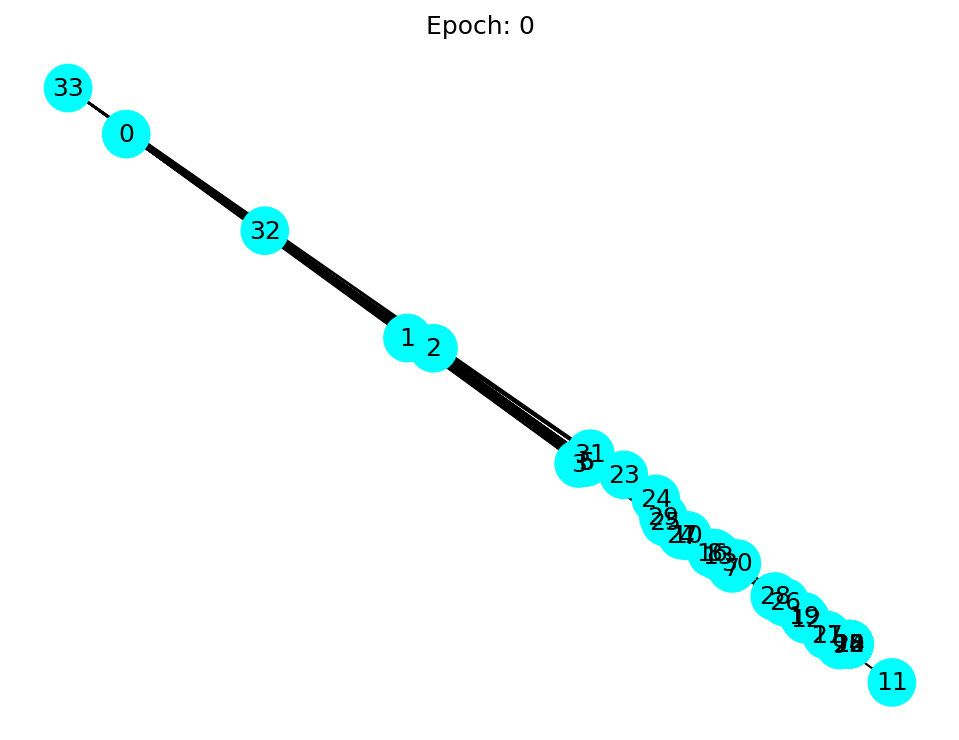

In [38]:
# Visualize the node classification using the logits output.
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = G.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = np.argmax(pos[v])
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=500)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

Advanced: writing arbitrary message and reduce function 
---

DGL provides many message and reduce functions to express different GNN variants. For instance, we support `u_mul_e` as message function and `max` as reduce function. A full list of built-in message and reduce functions can be found [here](https://docs.dgl.ai/features/builtin.html).

However, there is always a chance to go beyond this list. In DGL, you can define arbitrary message and reduce function in python function. Here is how you can define the same computation as the built-in `copy_u` and `sum`.

In [ ]:
# Same message function as `fn.copy_u`
def gcn_message_udf(edges):
    return {'m' : edges.src['h']}

# Same reduce function as `fn.sum`
def gcn_reduce_udf(nodes):
    return {'h' : nodes.mailbox['m'].sum(dim=1)}

However, using DGL's built-in functions is much faster because we can map them to efficient CPU/GPU kernels while user-defined python functions can only be invoked in python side.

Exercise: implementing the normalization
---
The GCN model we have implemented above uses the unnormalized adjacency matrix $A$. In this exercise, you will implement the normalization. Based on the equation:
$$
Y = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}XW
$$
, the message and reduce function will be rewritten as follows:
$$
\text{message phase: }m_{j\rightarrow i}=\frac{1}{\sqrt{d_j}}h_j
$$
$$
\text{reduce phase: }\tilde{h}_i=\frac{1}{\sqrt{d_i}}\sum_{j\in\mathcal{N}(i)}m_{j\rightarrow i}
$$

Now your task here is to implement this normalization.

Hint 1: you can use `G.in_degrees(G.nodes())` to get a 1-D tensor containing the degrees of all the nodes.

Hint 2: you can try UDF message function to perform multiplication between source node feature and edge feature. 

In [ ]:
G.in_degrees(G.nodes())

# DGL using MXNet

In [4]:
import dgl
import dgl.function as fn
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import autograd
import networkx as nx

# Load MXNet as backend
dgl.load_backend('mxnet')

G = dgl.DGLGraph(nx.karate_club_graph())
G.ndata['feat'] = nd.random.randn(34, 5)
# The broness edge feature is just a scalar.
G.edata['broness'] = nd.ones((G.number_of_edges(),))# The instructor (node 0) is a tough guy, so his friends are a little bit scared of him.
G.edges[G.predecessors(0), 0].data['broness'] *= 0.5


def message_func(edges):
    return {'m' : edges.src['h'] * edges.src['norm']}

reduce_func = fn.sum('m', 'h')

class GraphConv(gluon.Block):
    def __init__(self, in_feats, out_feats):
        super(GraphConv, self).__init__()
        self.linear = nn.Dense(out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # calculate norm = 1/sqrt(degree)
        norm = 1.0 / nd.sqrt(g.in_degrees(g.nodes()).astype('float32')).reshape(-1, 1)
        g.ndata['norm'] = norm
        # perform linear transformation
        h = self.linear(inputs)
        # set the node features
        g.ndata['h'] = h
        # trigger message passing, using the defined message_func and reduce_func.
        g.update_all(message_func, reduce_func)
        # get the result node features
        h = g.ndata.pop('h') * norm
        return h


# Define a 2-layer GCN model
class GCN(gluon.Block):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = nd.relu(h)
        h = self.conv2(g, h)
        return h

inputs = nd.eye(34)  # featureless inputs
labeled_nodes = nd.array([0, 33])  # only the instructor and the president nodes are labeled
labels = nd.array([0, 1])  # their labels are different

net = GCN(34, 5, 2)
net.initialize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.05})
loss_fn = gluon.loss.SoftmaxCELoss()

all_logits = []
for epoch in range(30):
    with autograd.record():
        logits = net(G, inputs)
        # we only compute loss for node 0 and node 33
        loss = loss_fn(logits[labeled_nodes], labels).sum()
    all_logits.append(logits.detach())

    loss.backward()
    trainer.step(batch_size=1)

    print('Epoch %d | Loss: %.4f' % (epoch, loss.asscalar()))

Epoch 0 | Loss: 1.3865
Epoch 1 | Loss: 1.3812
Epoch 2 | Loss: 1.3468
Epoch 3 | Loss: 1.2980
Epoch 4 | Loss: 1.2284
Epoch 5 | Loss: 1.1368
Epoch 6 | Loss: 1.0314
Epoch 7 | Loss: 0.9170
Epoch 8 | Loss: 0.7933
Epoch 9 | Loss: 0.6638
Epoch 10 | Loss: 0.5381
Epoch 11 | Loss: 0.4221
Epoch 12 | Loss: 0.3208
Epoch 13 | Loss: 0.2363
Epoch 14 | Loss: 0.1692
Epoch 15 | Loss: 0.1190
Epoch 16 | Loss: 0.0828
Epoch 17 | Loss: 0.0572
Epoch 18 | Loss: 0.0395
Epoch 19 | Loss: 0.0274
Epoch 20 | Loss: 0.0192
Epoch 21 | Loss: 0.0136
Epoch 22 | Loss: 0.0098
Epoch 23 | Loss: 0.0072
Epoch 24 | Loss: 0.0053
Epoch 25 | Loss: 0.0040
Epoch 26 | Loss: 0.0031
Epoch 27 | Loss: 0.0024
Epoch 28 | Loss: 0.0019
Epoch 29 | Loss: 0.0016


# DGL using Pytorch

In [37]:
import dgl
import dgl.function as fn

import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

# Load MXNet as backend
dgl.load_backend('pytorch')

G = dgl.DGLGraph(nx.karate_club_graph())
G.ndata['feat'] = torch.randn(34, 5)
# The broness edge feature is just a scalar.
G.edata['broness'] = torch.ones((G.number_of_edges(),))# The instructor (node 0) is a tough guy, so his friends are a little bit scared of him.
G.edges[G.predecessors(0), 0].data['broness'] *= 0.5

def message_func(edges):
    return {'m' : edges.src['h'] * edges.src['norm']}

reduce_func = fn.sum('m', 'h')

class GraphConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GraphConv, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # calculate norm = 1/sqrt(degree)
#         norm = 1.0 / nd.sqrt(g.in_degrees(g.nodes()).type('float32')).reshape(-1, 1)
        norm = 1.0 / torch.sqrt(G.in_degrees(G.nodes()).float()).reshape(-1, 1)
        g.ndata['norm'] = norm
        # perform linear transformation
        h = self.linear(inputs)
        # set the node features
        g.ndata['h'] = h
        # trigger message passing, using the defined message_func and reduce_func.
        g.update_all(message_func, reduce_func)
        # get the result node features
        h = g.ndata.pop('h') * norm
        return h

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GraphConv(in_feats, hidden_size)
        self.gcn2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# <<<

inputs = torch.eye(34)  # featureless inputs
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

net = GCN(34, 5, 2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
all_logits = []
for epoch in range(100):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for node 0 and node 33
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
# <<<

Epoch 0 | Loss: 1.0576
Epoch 1 | Loss: 0.9402
Epoch 2 | Loss: 0.8153
Epoch 3 | Loss: 0.6908
Epoch 4 | Loss: 0.5872
Epoch 5 | Loss: 0.5227
Epoch 6 | Loss: 0.4966
Epoch 7 | Loss: 0.4864
Epoch 8 | Loss: 0.4671
Epoch 9 | Loss: 0.4378
Epoch 10 | Loss: 0.4054
Epoch 11 | Loss: 0.3689
Epoch 12 | Loss: 0.3368
Epoch 13 | Loss: 0.3080
Epoch 14 | Loss: 0.2796
Epoch 15 | Loss: 0.2533
Epoch 16 | Loss: 0.2287
Epoch 17 | Loss: 0.2058
Epoch 18 | Loss: 0.1848
Epoch 19 | Loss: 0.1655
Epoch 20 | Loss: 0.1478
Epoch 21 | Loss: 0.1318
Epoch 22 | Loss: 0.1173
Epoch 23 | Loss: 0.1045
Epoch 24 | Loss: 0.0930
Epoch 25 | Loss: 0.0829
Epoch 26 | Loss: 0.0741
Epoch 27 | Loss: 0.0664
Epoch 28 | Loss: 0.0597
Epoch 29 | Loss: 0.0540
Epoch 30 | Loss: 0.0489
Epoch 31 | Loss: 0.0445
Epoch 32 | Loss: 0.0407
Epoch 33 | Loss: 0.0373
Epoch 34 | Loss: 0.0343
Epoch 35 | Loss: 0.0316
Epoch 36 | Loss: 0.0293
Epoch 37 | Loss: 0.0272
Epoch 38 | Loss: 0.0253
Epoch 39 | Loss: 0.0236
Epoch 40 | Loss: 0.0221
Epoch 41 | Loss: 0.0208
Ep